# Entrenamiento del modelo "bert-base-uncased" y el dataset "glue"

In [ ]:
# Instalar las librerías (no vienen por defecto en colab)
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding # <- DataCollatorWithPadding rellena todos los elementos de un lote para que tengan la misma longitud.

raw_datasets = load_dataset("glue", "mrpc") # cargamos el dataset y su tipo de evaluación
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [ ]:
### Usaremos dataloaders de nuevo (cargadores de datos)
print(f"Columnas antes: {tokenized_datasets['train'].column_names}")
print("----" * 20)

### Necesitamos remover columnas y cambiar nombres de ciertas variables
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels") #espera el nombre labels
tokenized_datasets.set_format("torch") #para usar pytorch

print(f"Columnas despues: {tokenized_datasets['train'].column_names}")
print("----" * 20)

# Ahora podremos definir los dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=True, batch_size=8, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

# Verificar
for batch in train_dataloader:
  break

print("Verificación del DataLoader:")
{k: v.shape for k, v in batch.items()}

Columnas antes: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']
--------------------------------------------------------------------------------
Columnas despues: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
--------------------------------------------------------------------------------
Verificación del DataLoader:


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 73]),
 'token_type_ids': torch.Size([8, 73]),
 'attention_mask': torch.Size([8, 73])}

## Usando Accelerate

In [ ]:
from accelerate import Accelerator
from transformers import get_scheduler, AutoModelForSequenceClassification
from torch.optim import AdamW
import evaluate
import torch
from tqdm.auto import tqdm

accelerator = Accelerator()
print(accelerator.device)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # labels nos dice que es clasificación binaria
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 5
num_training_steps = num_epochs * len(train_dl)

lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

# Barra de progreso y métrica
progress_bar = tqdm(range(num_training_steps))
all_metrics = []

model.train()
for epoch in range(num_epochs):
  metric = evaluate.load("glue", "mrpc") # <- MRCP clasifica si 2 oraciones significan lo mismo
  for batch in train_dl:
    outputs = model(**batch)
    loss = outputs.loss
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  # evaluación
  model.eval()
  for batch in eval_dl:
    with torch.no_grad():
      outputs = model(**batch)

      logits = outputs.logits # <- Obtenemos las salidas antes que softmax
      predictions = torch.argmax(logits, dim=-1) # Convertimos a clases entre "0" y "1"
      metric.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))

  result = metric.compute()
  print(f"Epoch: {epoch+1} -> Evaluación {result}")
  print("----" * 20)
  all_metrics.append(result)

cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2295 [00:00<?, ?it/s]

Epoch: 1 -> Evaluación {'accuracy': 0.8112745098039216, 'f1': 0.8560747663551402}
--------------------------------------------------------------------------------
Epoch: 2 -> Evaluación {'accuracy': 0.8651960784313726, 'f1': 0.9033391915641477}
--------------------------------------------------------------------------------
Epoch: 3 -> Evaluación {'accuracy': 0.8504901960784313, 'f1': 0.8988391376451078}
--------------------------------------------------------------------------------
Epoch: 4 -> Evaluación {'accuracy': 0.8602941176470589, 'f1': 0.8994708994708994}
--------------------------------------------------------------------------------
Epoch: 5 -> Evaluación {'accuracy': 0.8676470588235294, 'f1': 0.9055944055944056}
--------------------------------------------------------------------------------


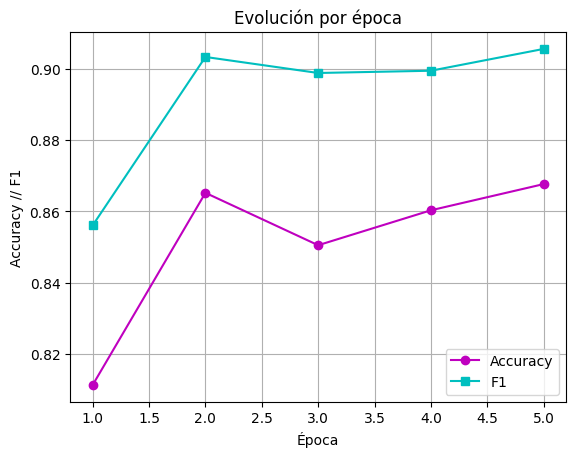

In [ ]:
import matplotlib.pyplot as plt

accuracies = [m["accuracy"] for m in all_metrics]
f1s = [z["f1"] for z in all_metrics]
plt.plot(range(1, num_epochs+1), accuracies, marker='o', c="m")
plt.plot(range(1, num_epochs+1), f1s, marker='s', c="c")
plt.title("Evolución por época")
plt.xlabel("Época")
plt.ylabel("Accuracy // F1")
plt.legend(["Accuracy", "F1"])
plt.grid()
plt.show()